# Introduzione

L'obiettivo è quello di analizzare il dataset sui funghi, e testare diversi classificatori per trovare il migliore nel classificare nuovi funghi come commestibili o velenosi. Il documento è composto come segue:

- Data Exploration
    - Analisi classi dataset
    - Feature Selection
    - Rimozione righe malformate
- Test Classificatori
    - Naive Bayes
    - Random Forest
    - ...
    - ...

Import delle librerie necessarie

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
#altri import futuri

Caricamento del dataset

In [4]:
dataset = pd.read_csv("dataset/secondary_data.csv", sep=";")
print("Dimension:", dataset.shape)
dataset.head()

Dimension: (61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


Split in Training e Testing set

In [39]:
target = dataset['class']

training_X, testing_X, training_Y, testing_Y = train_test_split(dataset.drop(columns = 'class'), target, test_size = 0.2, random_state=0)

training_X.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 12214 entries, 60661 to 4976
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          12214 non-null  float64
 1   cap-shape             12214 non-null  object 
 2   cap-surface           9395 non-null   object 
 3   cap-color             12214 non-null  object 
 4   does-bruise-or-bleed  12214 non-null  object 
 5   gill-attachment       10238 non-null  object 
 6   gill-spacing          7179 non-null   object 
 7   gill-color            12214 non-null  object 
 8   stem-height           12214 non-null  float64
 9   stem-width            12214 non-null  float64
 10  stem-root             1911 non-null   object 
 11  stem-surface          4715 non-null   object 
 12  stem-color            12214 non-null  object 
 13  veil-type             629 non-null    object 
 14  veil-color            1454 non-null   object 
 15  has-ring        

# Data Exploration

## Class Balancing

Siamo interessati a classificare i funghi come velenosi o meno, per questo motivo identifichiamo le due classi di interesse a partire dalla colonna "class" del dataset. Vogliamo vedere quanto sono bilanciate le classi del dataset

In [1]:
classes = [{"Commestibili": (dataset["class"] == "e").sum(), "Velenosi": (dataset["class"] == "p").sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Commestibili"])
total_p = float(total["Velenosi"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Edible','Poisonous'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#DA70D6'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

NameError: name 'dataset' is not defined

Vediamo che ci sono in percetuale il 10% in più di funghi velenosi, e questo può portare il classificatore a tendere nel classificare funghi come velenosi (falso positivo). Questo errore è meno grave del falso negativo (perche se ti dico che un fungo è velenoso comunque non lo mangi, il contrario invece è velenoso ti dico di no e muori). 

Possiamo pensare di ribilanciare le classi tramite oversampling o undersampling, oppure ancora meglio con SMOTE.

Rivalutare magari il class balancing dopo rimozione delle righe con valori nulli.

## Visualizzazione campi non nulli

Visualizzazione campi non nulli per ogni colonna/feature del dataset. Questo ci serve per vedere eventuali colonne che possono poi essere rimosse

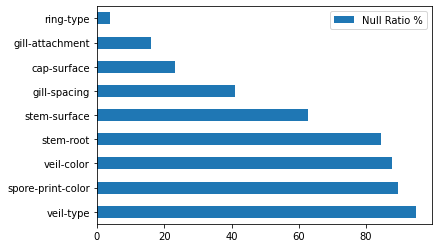

['veil-type', 'spore-print-color', 'veil-color', 'stem-root', 'stem-surface']

In [40]:
def plot_nas(training_X: pd.DataFrame, threshold, use_treshold):
    to_delete = []
    if training_X.isnull().sum().sum() != 0:
        na_training_X = (training_X.isnull().sum() / len(training_X)) * 100
        na_training_X = na_training_X.drop(na_training_X[na_training_X == 0].index).sort_values(ascending=False)
        to_delete = na_training_X[na_training_X > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_training_X})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (8,4)

        if use_treshold:
            plt.axvline(x=50, color='red')
            plt.text(45,-1,'thr = 50', color = 'red')
        plt.show()
        
    else:
        print('No NAs found')
    return to_delete.index.tolist()
        

plot_nas(training_X,50,False)

## Feature Visualization

Visualizziamo il numero di classi per ogni feature in modo da visualizzare possibili colonne da rimuovere perche con valori costanti o quasi.

In [ ]:
categ = [ 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
conti = ['stem-height', 'stem-width', 'cap-diameter']
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']

fig = plt.figure(figsize=(25,20))
for i in range(0, len(categ)):
    fig.add_subplot(5,4,i+1)
    sns.countplot(x=categ[i], data=training_X, alpha=.7) 

for col in conti:
    fig.add_subplot(5,4,i+2)
    i+=1
    sns.histplot(training_X[col].dropna(), kde_kws={"lw": 2, "color":colors[8]})

Analizzando la distribuzione delle varie features è evidente che la feature ```veil-type``` possa essere rimossa dall'insieme delle features. Questo perché presenta soltanto 3177 valori non nulli, e di valore costante ```u```.

In [ ]:
training_X = training_X.drop(columns = "veil-type")

## Conversione Features e Mapping

Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da ```object``` in ```category``` per poi procedere con l'effettiva trasformazione dei valori categorici.

Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [ ]:
class LabelEncoderByCol(BaseEstimator, TransformerMixin):
    def __init__(self,col):
        self.col = col
        self.encoders = {}
        self.mapping = []
        for el in self.col:
            self.encoders[el] = LabelEncoder()
            
    def fit(self,x,y=None):
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            a = x[el][x[el]!='NaN']
            self.encoders[el].fit(a)
        return self

    def transform(self,x,y=None):
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            if (x[el].dtype == "object") :
                a = x[el][x[el]!='NaN']
                b = x[el].to_numpy()
                b[b!='NaN'] = self.encoders[el].transform(a)
                x[el]=b
                mapping_dict = {index : label for index , label in enumerate(self.encoders[el].classes_)}
                self.mapping.append(mapping_dict)
        return x

In [ ]:
encoder = LabelEncoderByCol(training_X.columns)
encoder.fit(training_X)
mapped_dataset = encoder.transform(training_X)

Completiamo trasformando il tipo di dato associato alle features categoriche da ```object``` in ```Int64```, oggetto che accetta valori interi nulli.

In [ ]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('Int64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili ordinali. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [ ]:
mapped_dataset.head()

## Feature Correlation

Vediamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia altamente correlata con il target (quindi che il suo valore sia importante per discriminare se il fungo è positivo o negativo). Una correlazione alta è sia positiva (aumento del valore di uno aumenta il valore dell'altro) che negativa (aumento del valore di uno diminuisce il valore dell'altro). Una correlazione vicina allo zero implica che le variabili sono indipendenti tra loro.

In [ ]:
mapped_dataset.head()

In [ ]:
plt.figure(figsize=(16,12))
correlation_matrix = mapped_dataset.corr()
sns.heatmap(correlation_matrix, linewidths=.1, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, annot_kws={"size": 8})
plt.yticks(rotation=0)
plt.show()

## Feature Selection

Si selezionano le feature più utili ai fini della classificazione

### Rimozione di features con dati costanti

Primo approccio base di feature selection andiamo a rimuovere le feature con varianza nulla presenti nel training_X, ovvero quelle features il cui valore è costante.   
Dalla fase di Data Visualization abbiamo notato che una features con varianza nulla è il veil-type.
 
Applicando una Variance Threshold pari al 20% vengono rimosse le features ```does-bruise-or-bleed``` e ```has-ring```  
  
TODO rivalutare dopo se abbassandola migliora la classificazione 

In [ ]:
selector = VarianceThreshold(0.2)
selector.fit(mapped_dataset)
mapped_dataset = mapped_dataset.loc[:, selector.get_support()]  # get_support() effettua la transform e ritorna l'indice delle colonne rimosse

### Rimozione di features con valori nulli

Si cancellano le features che presentano più del 50% di valori nulli. Per le colonne con meno del 50% di valori nulli si utilizza invece un meccanismo di imputazione per sopperire alla presenza di dati mancanti in quelle features da scartare ma che hanno buona correlazione (vd. dopo) con la variabile target e buona distribuzione dei valori.

Tra queste features con 50% valori nulli controlliamo la correlazione con la variabile target perché features con pochi valori, ma comunque significativi nella discriminazione con la classe possono migliorare 

- Otteniamo la lista di features che superano la soglia del 50%

In [ ]:
to_delete = plot_nas(training_X,50,True)

- Verifichiamo quali tra queste features hanno una correlazione bassa con il target

In [ ]:
td = []
cor_tre = 0.4

for feature in to_delete:
    ind = training_X.columns.get_loc(feature)
    target_corr = correlation_matrix.values[0][ind]
    print("feature: " + feature + " | " + str(target_corr))

    if (target_corr>=-cor_tre and target_corr<0) or (target_corr<=cor_tre and target_corr>0):
        td.append(feature)

- Rimuoviamo tali features dal dataset

In [ ]:
mapped_dataset = mapped_dataset.drop(columns = td)

### Features Selezionate

In [ ]:
mapped_dataset.head()

## Imputazione delle features con valori nulli

Si utilizza un meccanismo di imputazione per sopperire alla presenza di dati mancanti per le features da scartare per la politica scelta (nan < 50%), ma che presentano una buona correlazione con la variabile target e una buona distribuzione dei valori.
Ovviamente il meccanismo è applicato anche a quelle features con meno del 20% di valori nulli, così da ripristinare la variabile per l'uso nella classificazione rimpiazzando tutti i dati mancanti.

In [ ]:
imp = KNNImputer(n_neighbors=1, weights='uniform')
imputedDataset = pd.DataFrame(imp.fit_transform(mapped_dataset), columns = mapped_dataset.columns)
print(imputedDataset[7].value_counts())